# What drives heterogeneity in the MPC (circumstances view vs. characteristics view)

Michael Gelman

Presented by Jionglin (Andy) Zheng

Python version: 3.8.5

HARK version: 0.11.0

## Summary

The paper discusses the relative importance of circumstances view and characteristics view in explaining the variance of the MPC
  
Main findings:  
* the paper compares the average cash on hand distribution simulated in the model to the empirical distribution estimated from the data, and the model matches the empirical distribution fairly well
* the paper finds that within- and across-individual differences in cash on hand play roughly equal roles in explaining MPC variance (characteristics variance share is about 0.45)

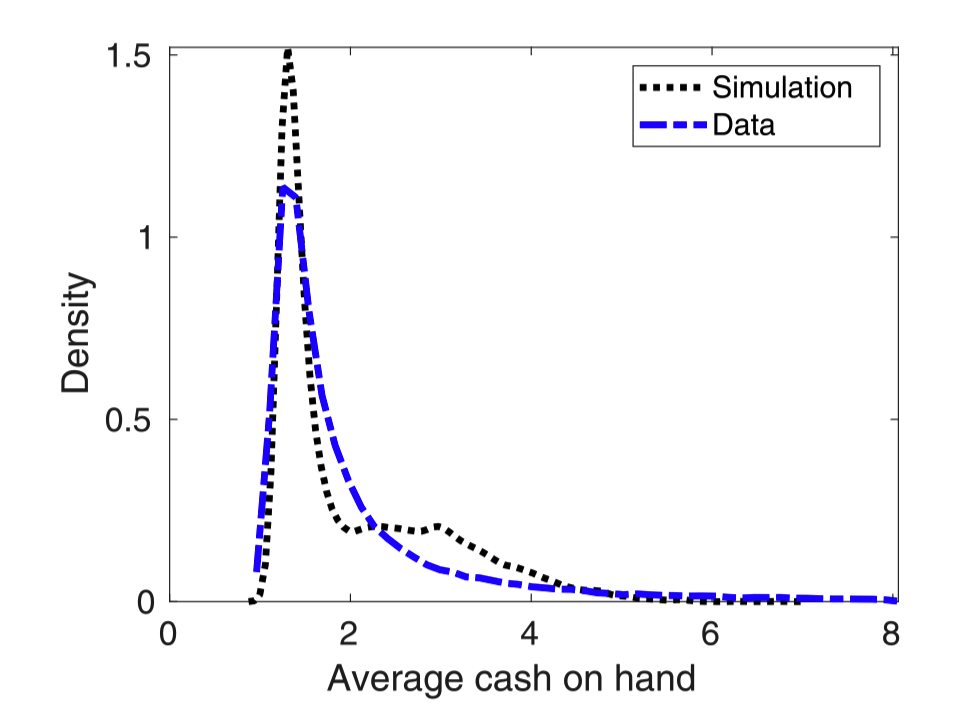

## The Model
### Model description
Optimization problem of individual $i$ solves the following utility maximization problem:

\begin{eqnarray*}
&\max_{\left\{C_{i j}\right\}_{j=t}^{\infty}}& \mathbb{E}_{t}\left[\sum_{j=t}^{\infty} \beta_{i}^{j-t} \frac{C_{i j}^{1-\theta}}{1-\theta}\right]\\
\notag & \text{subject to}& \\
&A_{i t+1}&=(1+r)\left(A_{i t}+Y_{i t}-C_{i t}\right) \\
&A_{i t+1}& \geq b \\
&Y_{i t}&=\bar{Y}_{i} \varepsilon_{i t} \\
&\varepsilon_{i t}& \stackrel{i i d}{\sim} N\left(1, \sigma_{Y}^{2}\right)
\end{eqnarray*}

where $\beta_{i}, r, C_{it}, A_{it}$ and $Y_{it}$ represents the time discount factor, the interest rate, consumption, liquid assets, and income respectively.



The Bellman form of the value function for individuals is:

\begin{eqnarray*}
V\left(x_{i t}\right) &=& \max _{a_{i t+1}}\left\{u\left(c_{i t}\right)+\beta_{i} \mathbb{E}\left[V\left(x_{i t+1}\right)\right]\right\}
\notag &\text{s.t.}&\\
x_{i t+1} &=& (1+r)\left(x_{i t}-c_{i t}\right)+y_{i t+1},\\
\end{eqnarray*}
and previous constraints.

Substituting in for $c_{i t}$ and $x_{i t+1}$ results in an equation in terms of $x_{i t}, a_{i t+1},$ and $y_{i t+1}$, where $x_{it}$ is cash-on-hand.

\begin{align*}
V\left(x_{i t}\right)=\max _{a_{i t+1}}\left\{u\left(x_{i t}-\frac{a_{i t+1}}{1+r}\right)+\beta_{i} \mathbb{E}\left[V\left(a_{i t+1}+y_{i t+1}\right)\right]\right\}
\end{align*}

### Circumstances and characteristics view
* temporary circumstances
    - $\beta_i = \bar{\beta}$ 
* persistent characteristics
    - $\beta_i \sim \; U(\bar{\beta} - \Delta, \bar{\beta} + \Delta)$
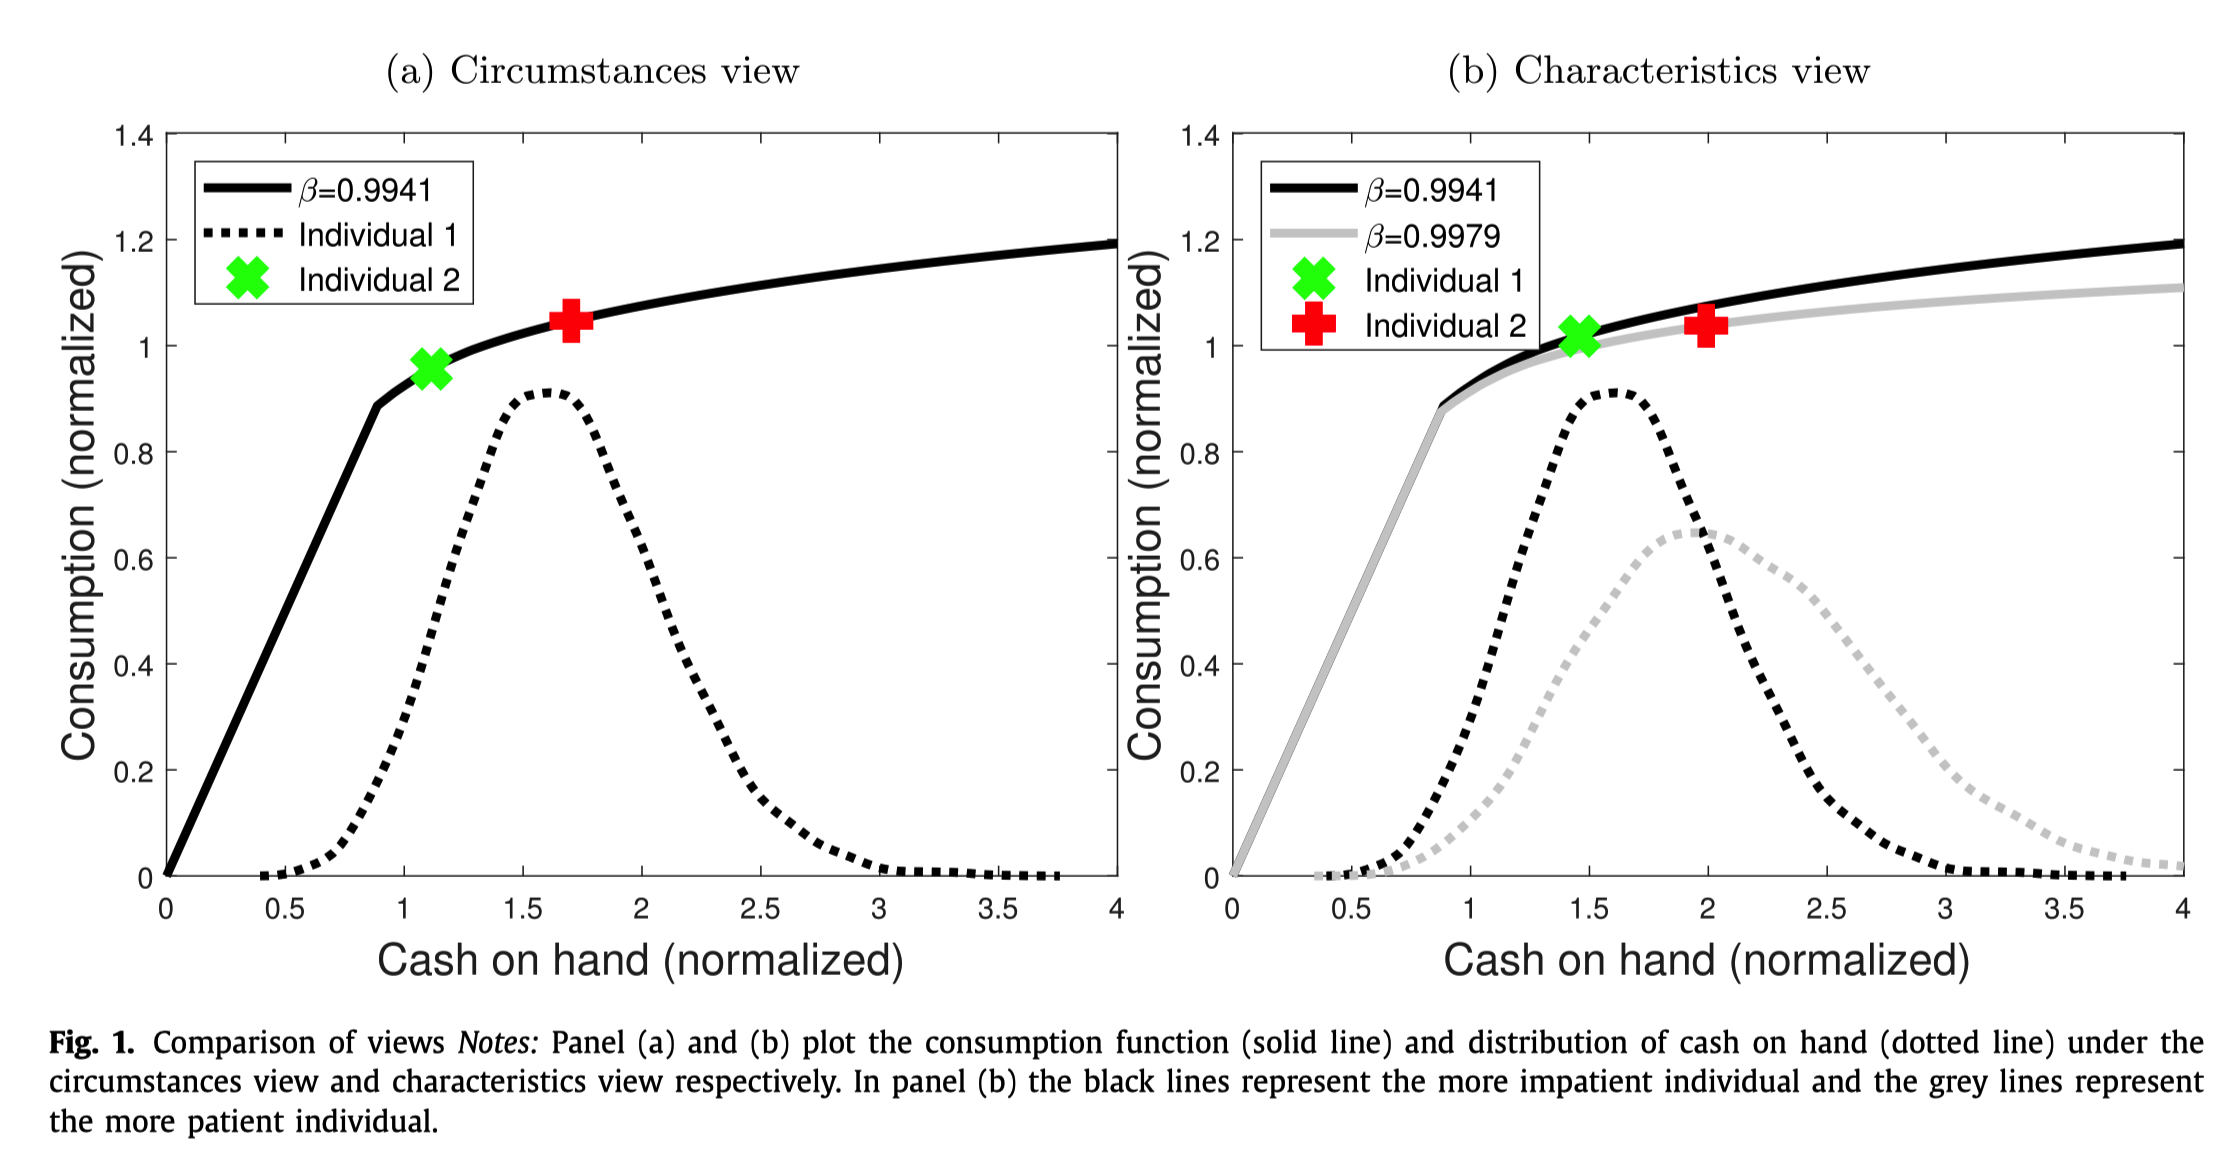

#### replication using HARK (figure 1)
* calibration
\begin{aligned}
&\begin{array}{llll}
\hline \text { Parameter } & \text { Value } & \text { Notes } & \text { Description } \\
\hline u(x) & \frac{x^{1-\theta}}{1-\theta} & \text { CRRA utility } & \text { utility function } \\
\theta & 1 & \text { standard } & \text { coefficient of relative risk aversion } \\
\bar{\beta} & 0.9941 & & \text { average discount factor } \\
\Delta & 0.0190 & 0 \text { for circumstance model } & \text { discount factor dispersion } \\
\sigma_{Y} & 0.20 & \text { estimated from dataset } & \text { S.D. of temporary shocks } \\
\text {refund}_{i t} & 0.60 & \text { estimated from dataset } & \text { average normalized refund } \\
r & 0.01 / 12 & \text { monthly } r \text { on checking/saving } & \text { interest rate } \\
b & 0 & \text { no borrowing condition } & \text { borrowing limit } \\
\hline
\end{array}\\
&\text { Notes: The parameters correspond to a monthly frequency. }
\end{aligned}

#### HARK result (figure 1)

In [1]:
import HARK
HARK.__version__

# This cell does some standard python setup

# Tools for navigating the filesystem
import sys
import os

import csv
import os.path

# Import related generic python packages
import numpy as np
import math
mystr = lambda number : "{:.4f}".format(number)
from copy import copy, deepcopy

# Plotting tools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show

import pandas as pd

# iPython gives us some interactive and graphical tools
from IPython import get_ipython # In case it was run from python instead of ipython

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

from HARK.utilities import plot_funcs

In [2]:
# simulation for distribution of cash on hand
IdiosyncDict={
    # Parameters shared with the perfect foresight model
    "CRRA": 1.00000000000001,                           # Coefficient of relative risk aversion
    "Rfree": 1 + 0.01/12,                         # Interest factor on assets
    "DiscFac": 0.9941,                       # Intertemporal discount factor, monthly frequency
    "LivPrb" : 12*[1.0],                     # Survival probability, 0.99979
    "PermGroFac" : 12*[1.0],                  # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : 12*[0.0000000000000001],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 0,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : 12*[0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.00,                     # Probability of unemployment while working
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other paramaters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 12,                         # Number of periods in the cycle for this agent type
                                           # quarterly data

    # Parameters only used in simulation
    "AgentCount" : 1,                  # Number of agents of this type
    "T_sim" : 5000,                         # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

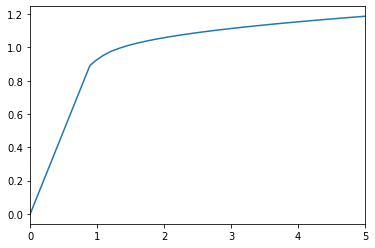

{'aNrm': array([[0.08528343],
        [0.17732964],
        [0.19072277],
        ...,
        [0.        ],
        [0.35161468],
        [0.66563151]]),
 'mNrm': array([[1.01800336],
        [1.14075673],
        [1.15788694],
        ...,
        [0.71732977],
        [1.34970321],
        [1.7016109 ]]),
 'cNrm': array([[0.93271993],
        [0.96342709],
        [0.96716417],
        ...,
        [0.71732977],
        [0.99808854],
        [1.03597939]]),
 'pLvl': array([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])}

In [3]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

IndShockSimExample = IndShockConsumerType(**IdiosyncDict)
IndShockSimExample.cycles = 0 # Make this type have an infinite horizon
IndShockSimExample.solve()

plot_funcs(IndShockSimExample.solution[0].cFunc,IndShockSimExample.solution[0].mNrmMin,5)

# simulation
IndShockSimExample.track_vars = ['aNrm','mNrm','cNrm','pLvl']
IndShockSimExample.initialize_sim()
IndShockSimExample.simulate()

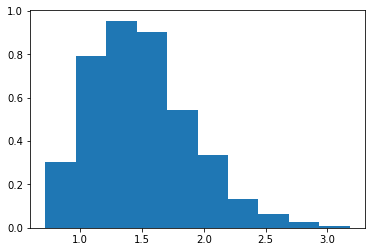

In [4]:
# distribution of cash on hand
density = np.histogram(IndShockSimExample.history['mNrm'], density=True)#print(density)
n, bins, patches = plt.hist(IndShockSimExample.history['mNrm'], density = True)

<AxesSubplot:title={'center':'distribution of cash on hand'}, ylabel='Density'>

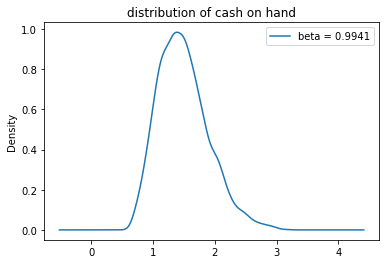

In [5]:
df1 = pd.DataFrame(IndShockSimExample.history['mNrm'], columns = ['beta = 0.9941'] ) #Converting array to pandas DataFrame
df1.plot(kind = 'density', title = 'distribution of cash on hand')

In [6]:
# circumstances view
IndShockSimExample2 = deepcopy(IndShockSimExample)
IndShockSimExample2.DiscFac = 0.9979
IndShockSimExample2.update_income_process()
IndShockSimExample2.solve()

IndShockSimExample2.track_vars = ['aNrm','mNrm','cNrm','pLvl']
IndShockSimExample2.initialize_sim()
IndShockSimExample2.simulate()

{'aNrm': array([[0.09874303],
        [0.03819494],
        [0.04800051],
        ...,
        [0.65842571],
        [0.99673291],
        [1.13062562]]),
 'mNrm': array([[1.01800336],
        [0.93446918],
        [0.94902994],
        ...,
        [1.65254298],
        [2.00867761],
        [2.14827173]]),
 'cNrm': array([[0.91926034],
        [0.89627424],
        [0.90102943],
        ...,
        [0.99411727],
        [1.01194471],
        [1.01764611]]),
 'pLvl': array([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])}

(array([0.13222795, 0.5323763 , 0.70560069, 0.58318879, 0.3984161 ,
       0.30949425, 0.16109869, 0.05023507, 0.01097088, 0.00346449]), array([0.71732977, 1.06370131, 1.41007286, 1.7564444 , 2.10281594,
       2.44918748, 2.79555902, 3.14193056, 3.4883021 , 3.83467364,
       4.18104519]))


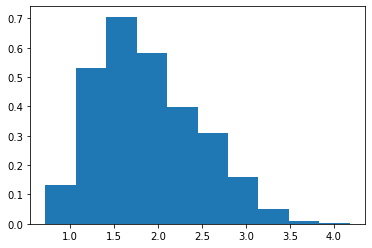

In [7]:
density = np.histogram(IndShockSimExample2.history['mNrm'], density=True)
print(density)
n, bins, patches = plt.hist(IndShockSimExample2.history['mNrm'], density = True)

<AxesSubplot:ylabel='Density'>

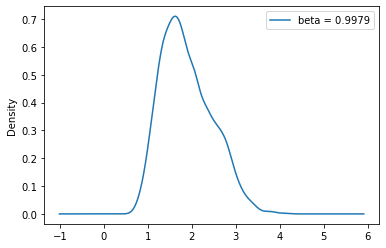

In [8]:
df2 = pd.DataFrame(IndShockSimExample2.history['mNrm'], columns = ['beta = 0.9979'] ) #Converting array to pandas DataFrame
df2.plot(kind = 'density', label = 'beta = 0.9941')

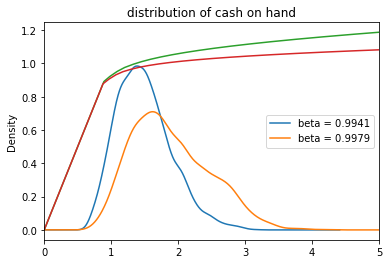

In [9]:
# plot two densities on a single figure & draw consumption funcs
ax = df1.plot(kind = 'density')
df2.plot(ax = ax, kind = 'density', title = 'distribution of cash on hand')

# Final consumption function c=m
m = np.linspace(0.1,1,100)
plot_funcs([IndShockSimExample.solution[0].cFunc, IndShockSimExample2.solution[0].cFunc],0.,5.)

#### comparing HARK replication with Gelman figure 1
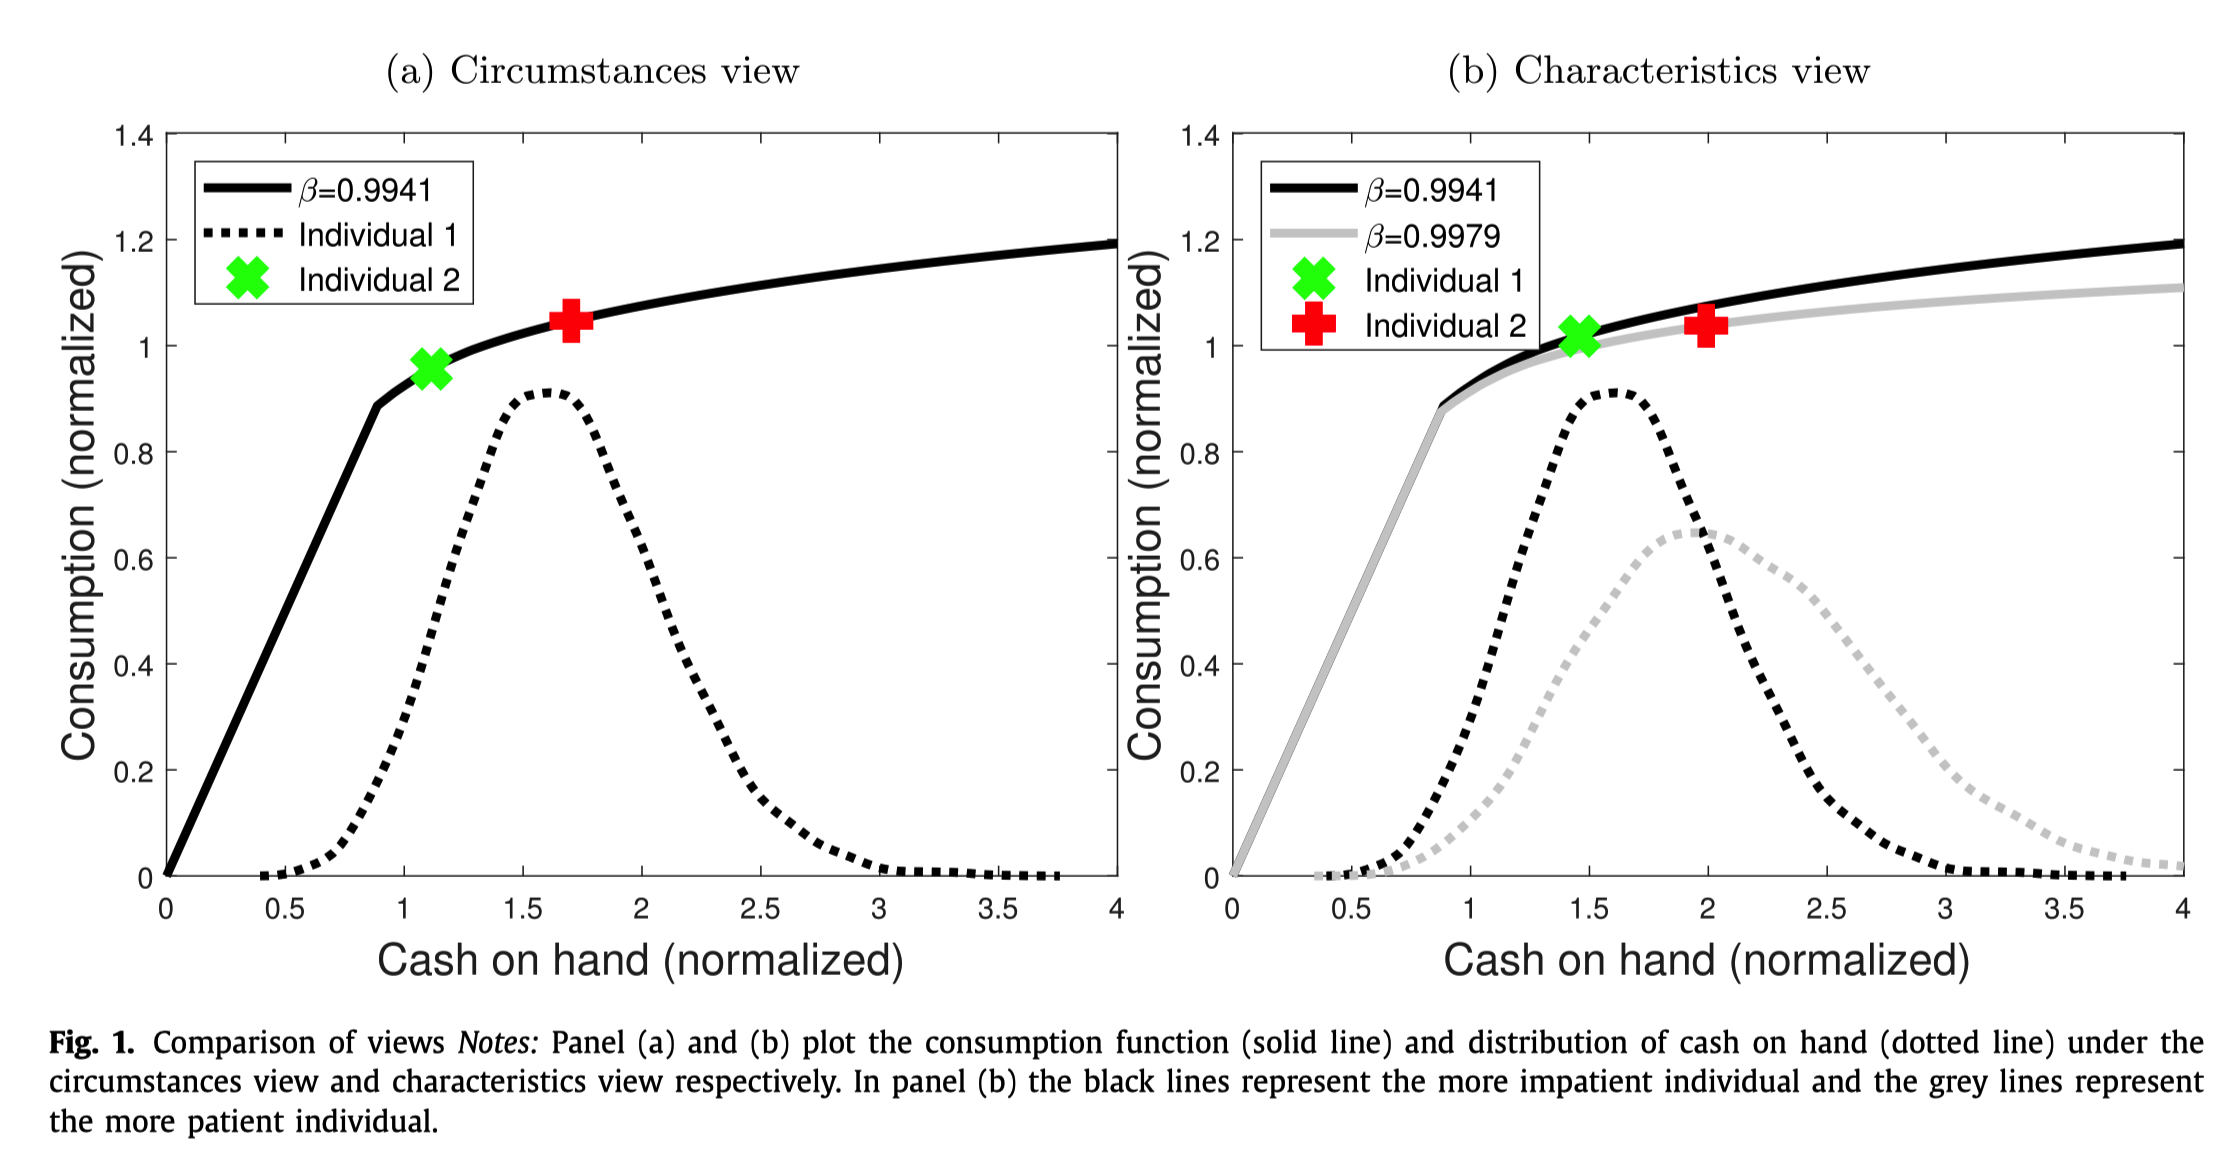

#### HARK result (figure 2)

In [10]:
# write beta_list and target level wealth to file
IndShockSimExample3 = deepcopy(IndShockSimExample)
IndShockSimExample3.CRRA = 1.62
IndShockSimExample3.DiscFac = 0.99

'''
calculate target level of wealth to different betas

@param: 
    filename  : name of the file to store all the values; delimiter is set to be ' '
    startValue: x axis limit of beta; ending value is set to be 0.9989
'''
def generate_TBS_Lvl_to_beta(filename, startValue):
    f = open(filename, 'w')
    beta = startValue
    
    while (beta <= 0.9989):
        IndShockSimExample3.DiscFac = beta
        IndShockSimExample3.update_income_process()
        IndShockSimExample3.solve()

        targetLvlWealth = IndShockSimExample3.solution[0].mNrmTrg

        f.write(str(beta) + ' ')  # Write beta
        f.write(str(targetLvlWealth) + '\n')
        f.flush()
        
        # error message
        if(beta <= 0.998):
            beta += 0.00005
        elif((beta > 0.998) and (beta <=0.9988)):
            beta += 0.0015

    f.close()
    

'''
plot discount factor vs. target buffer stock, figure 2

@param: filename
'''
def plot_TBS_level_to_beta(filename):
    f = open(os.path.abspath(filename), 'r')
    my_reader = csv.reader(f, delimiter=' ')
    raw_data = list(my_reader)
    
    targetLvl = []
    beta_list = []
    
    for i in range(len(raw_data)):
        beta_list.append(float(raw_data[i][0]))
        targetLvl.append(float(raw_data[i][1]))
    beta_list = np.array(beta_list)
    targetLvl = np.array(targetLvl)
    f.close()

    plt.plot(beta_list, targetLvl, '-k', color='b', linewidth=1.5)
    plt.xlabel(r'discount factor $\beta$',fontsize=12)
    plt.ylabel('Target buffer stock',fontsize=12)
    plt.title('figure 2: target buffer stock and the discount factor',fontsize=12)
    plt.ylim(1.3, 2.0)
    #plt.savefig('./figure3_reproduction.pdf')
    plt.show()    

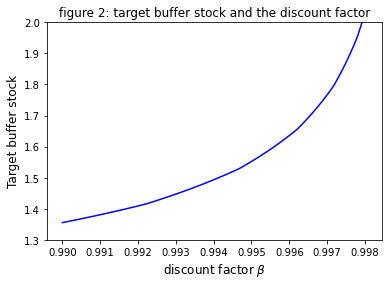

In [11]:
# plot discount factor vs. target buffer stock, figure 2
filename = 'TBS_Lvl_to_beta.txt'

try:
    if(os.path.isfile(filename)):
        plot_TBS_level_to_beta(filename)
    else:
        print('file does not exist. file will be generated to plot the graph.')
        generate_TBS_Lvl_to_beta(filename, 0.99)
        plot_TBS_level_to_beta(filename)
except OSError: 
    '''
    This exception is raised when a system function returns a system-related error, 
    including I/O failures such as “file not found” or “disk full” 
    (not for illegal argument types or other incidental errors).
    '''
    print('file error.')


##### original figure in paper

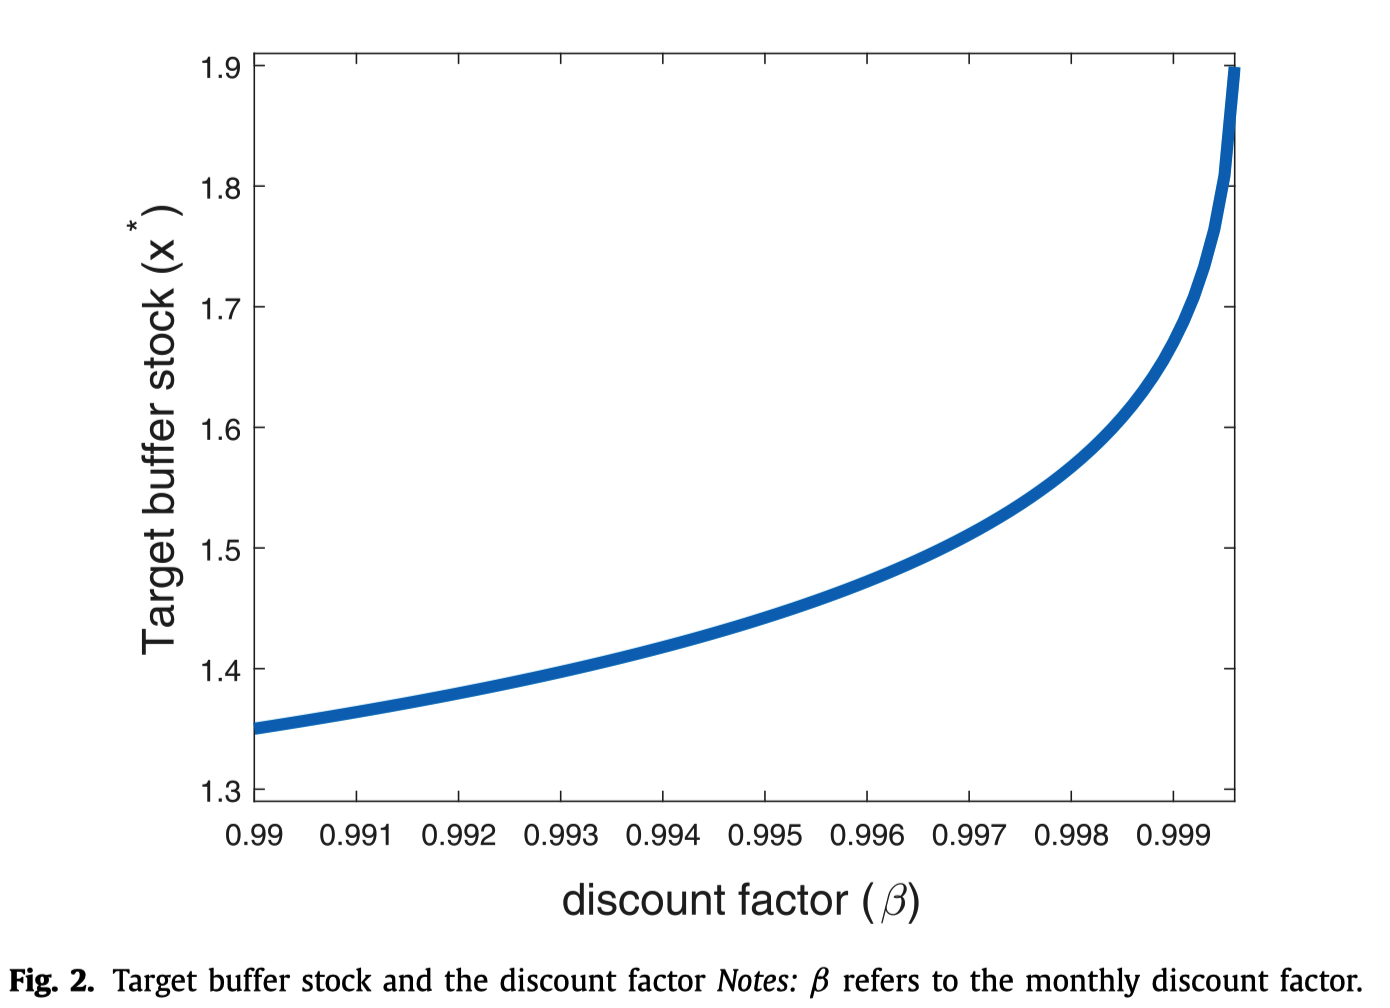

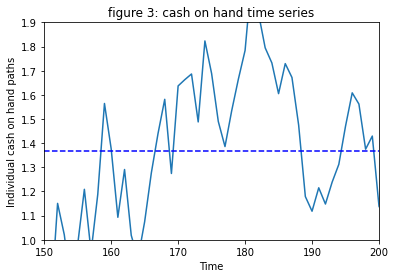

1.3665654495617847


In [12]:
# figure 3
plt.plot(IndShockSimExample.history['mNrm'])
plt.xlabel('Time')
plt.ylabel('Individual cash on hand paths')
plt.xlim(150, 200)
plt.ylim(1.0, 1.9)
plt.axhline(y=IndShockSimExample.solution[0].mNrmTrg, color='b', linestyle='--') # target level of wealth
plt.title('figure 3: cash on hand time series',fontsize=12)
plt.show()

print(IndShockSimExample.solution[0].mNrmTrg) #value of (normalized) market resources m at which individual consumer expects m not to change

##### original figure in paper

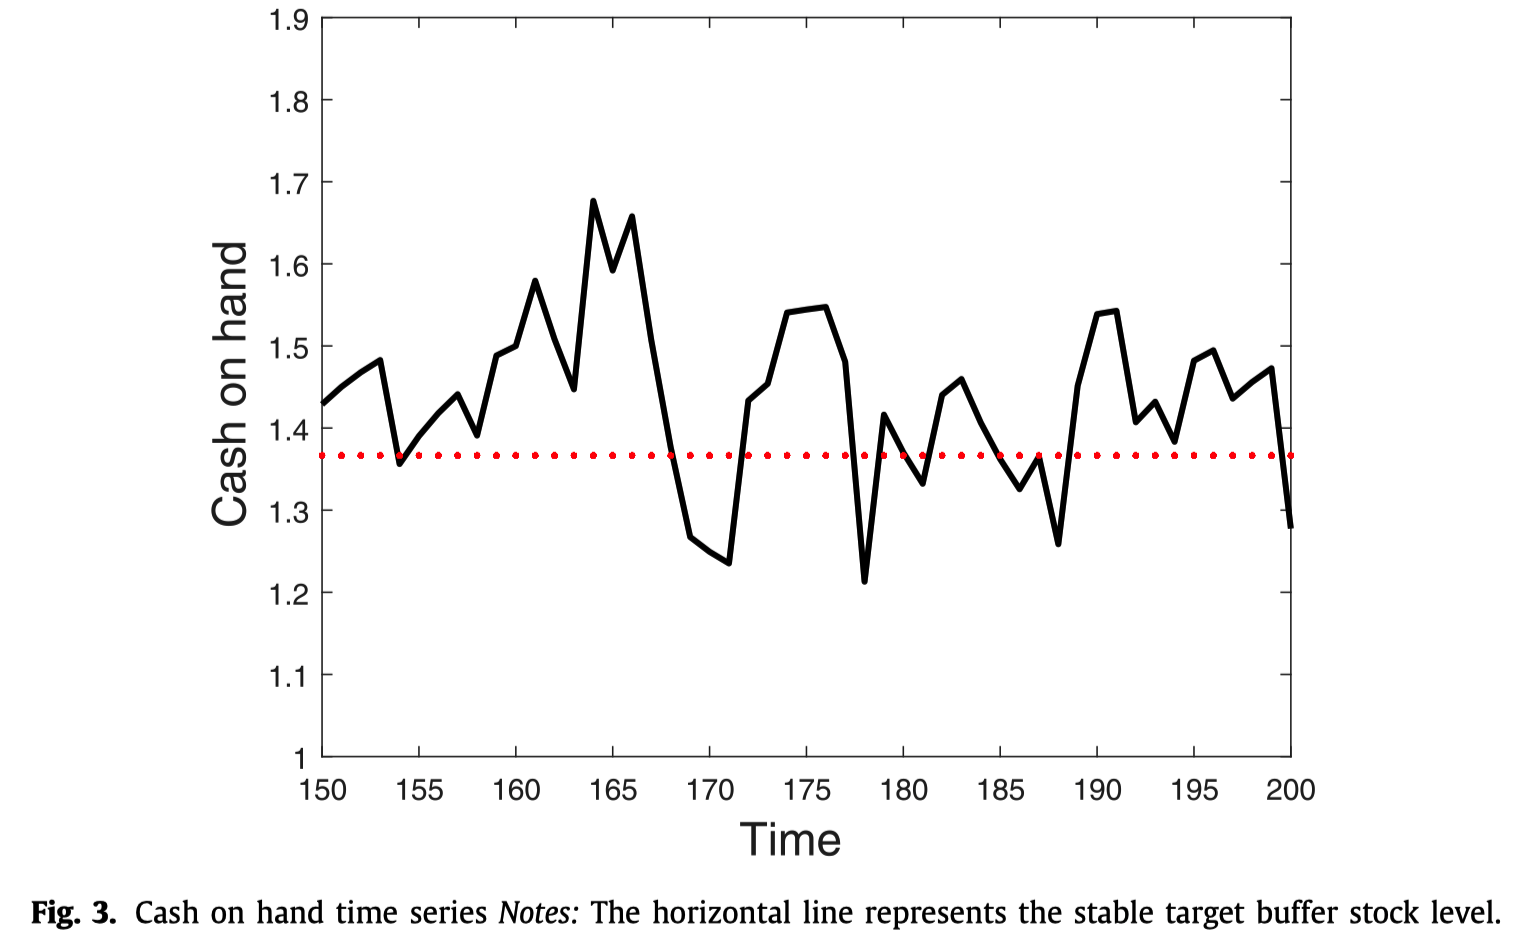

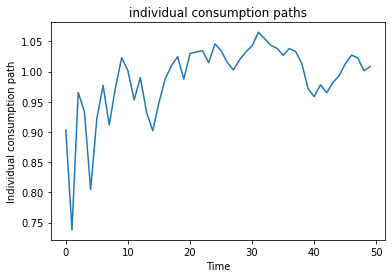

In [13]:
plt.plot(IndShockSimExample.history['cNrm'][150:200,0:5]) #individual consumption paths for first 5
plt.xlabel('Time')
plt.ylabel('Individual consumption path')
plt.title('individual consumption paths', fontsize=12)
plt.show()

### Model simulation
* simulates the consumption response to income under the two views
    - The simulation environment is chosen to match the empirical environment very closely
* the author simulates the consumption reaction of 200 individuals to the receipt of a tax refund every 12 months over a period of 4 years
    - For each tax refund received, the author calculates the MPC and cash on hand of each individual

#### Variable definitions
* main variables used in the analysis are the MPC and cash on hand
    - MPC at time $t$ for individual $i$
        - $MPC_{i t}=\frac{\Delta C_{i t}}{\Delta Y_{i t}}=\frac{\sum_{j=t}^{t+2} c_{i j}-\sum_{j=t-1}^{t-3} c_{i j}}{refund_{it}}$
    - Pre-refund cash on hand at time $t$ for individual $i$
        - $coh_{i t}^{P R}=\frac{\sum_{j=t-1}^{t-3} x_{i j}}{3}$
    - Average cash on hand for individual $i$
        - $\overline{c o h}_{i}=\frac{\sum_{j=t}^{T} x_{i j}}{T}$

#### The relationship between MPC and cash on hand (original figure in paper)
* under the circumstances view
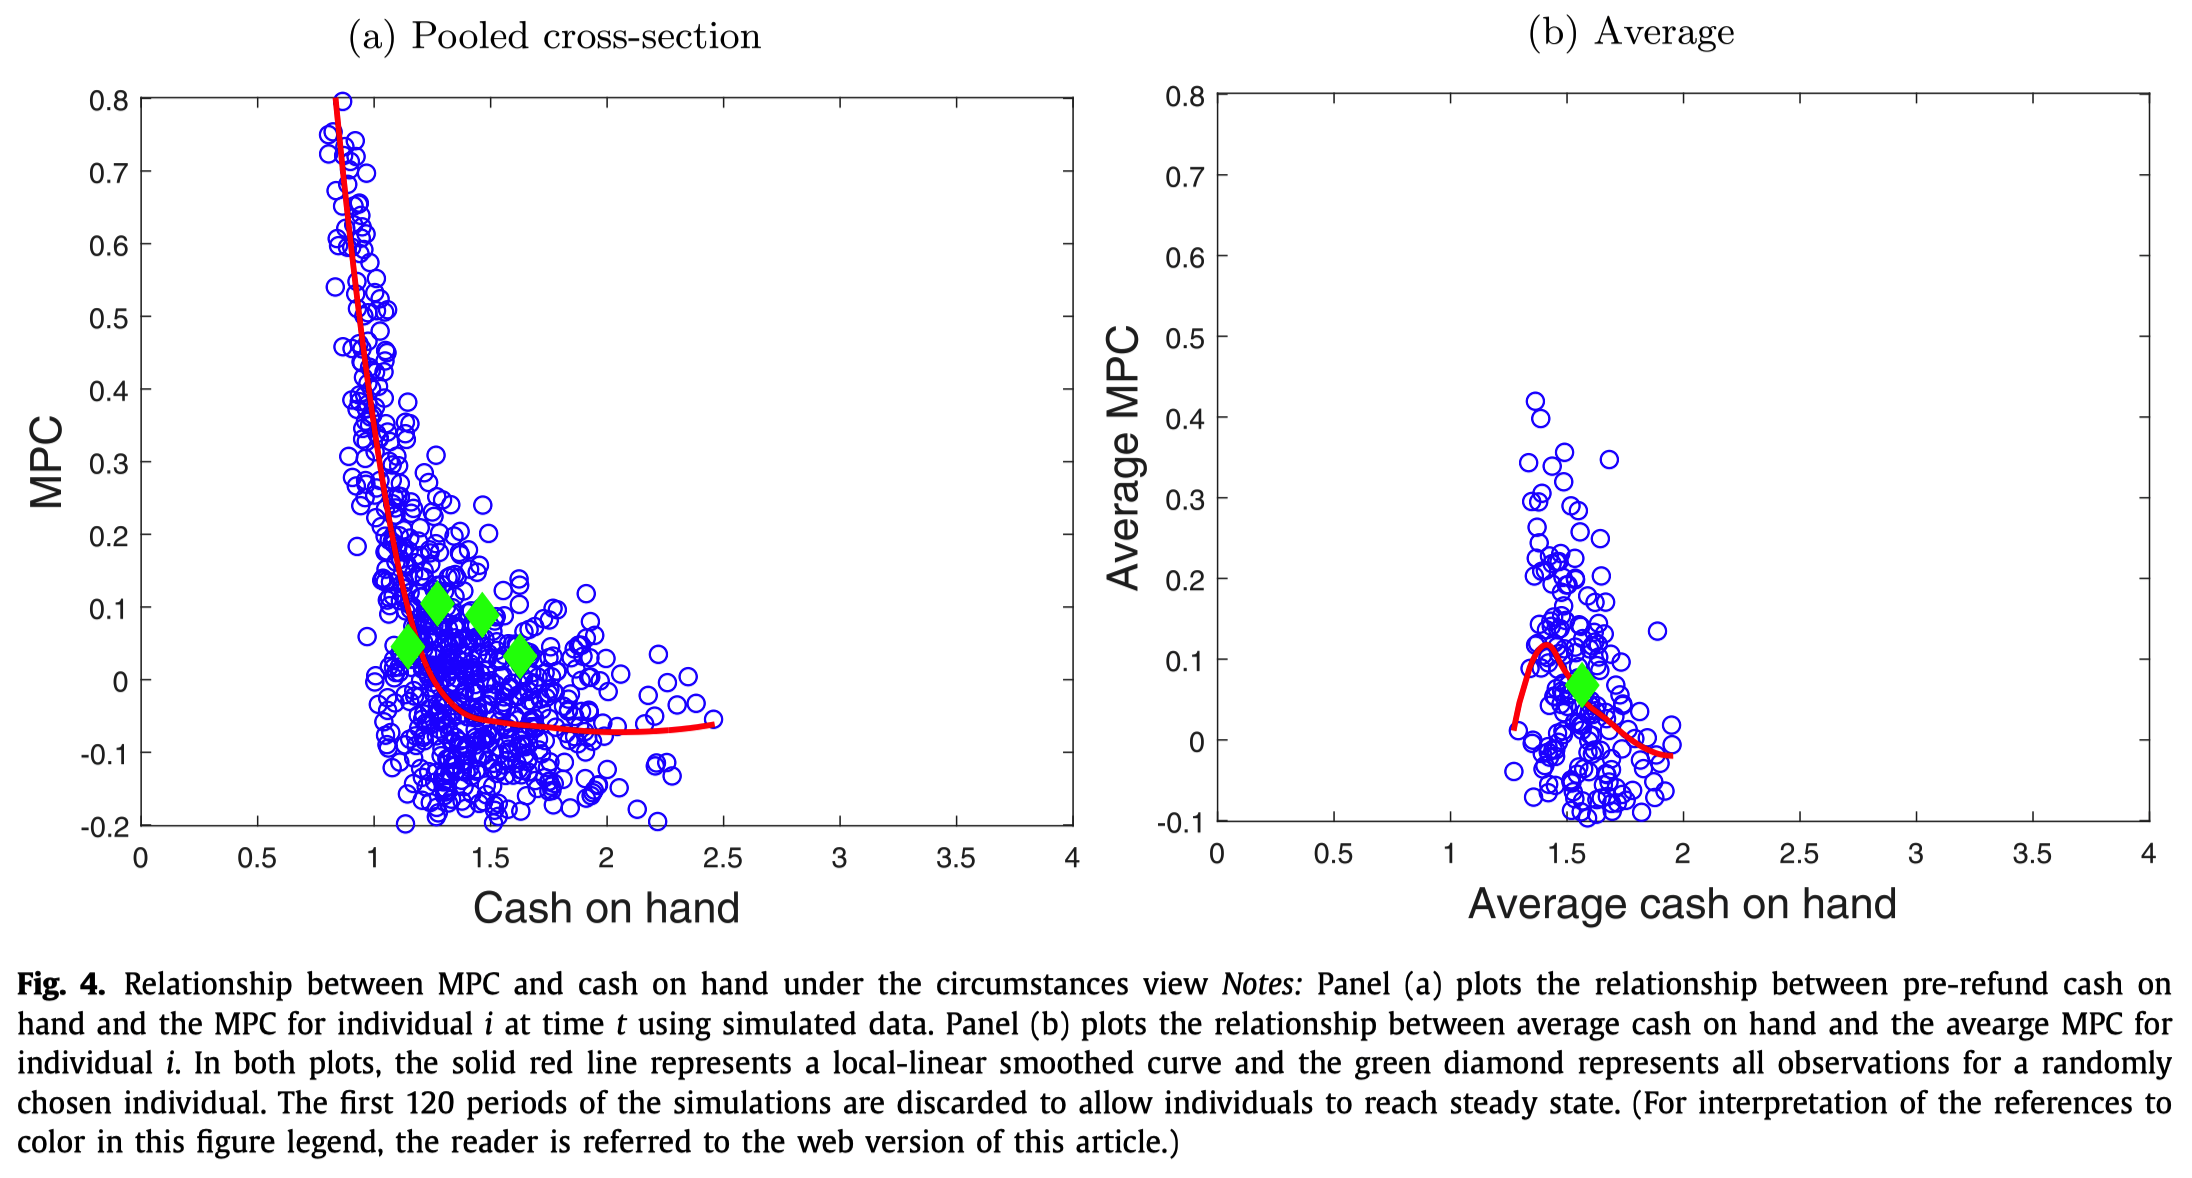

* under the characteristics view
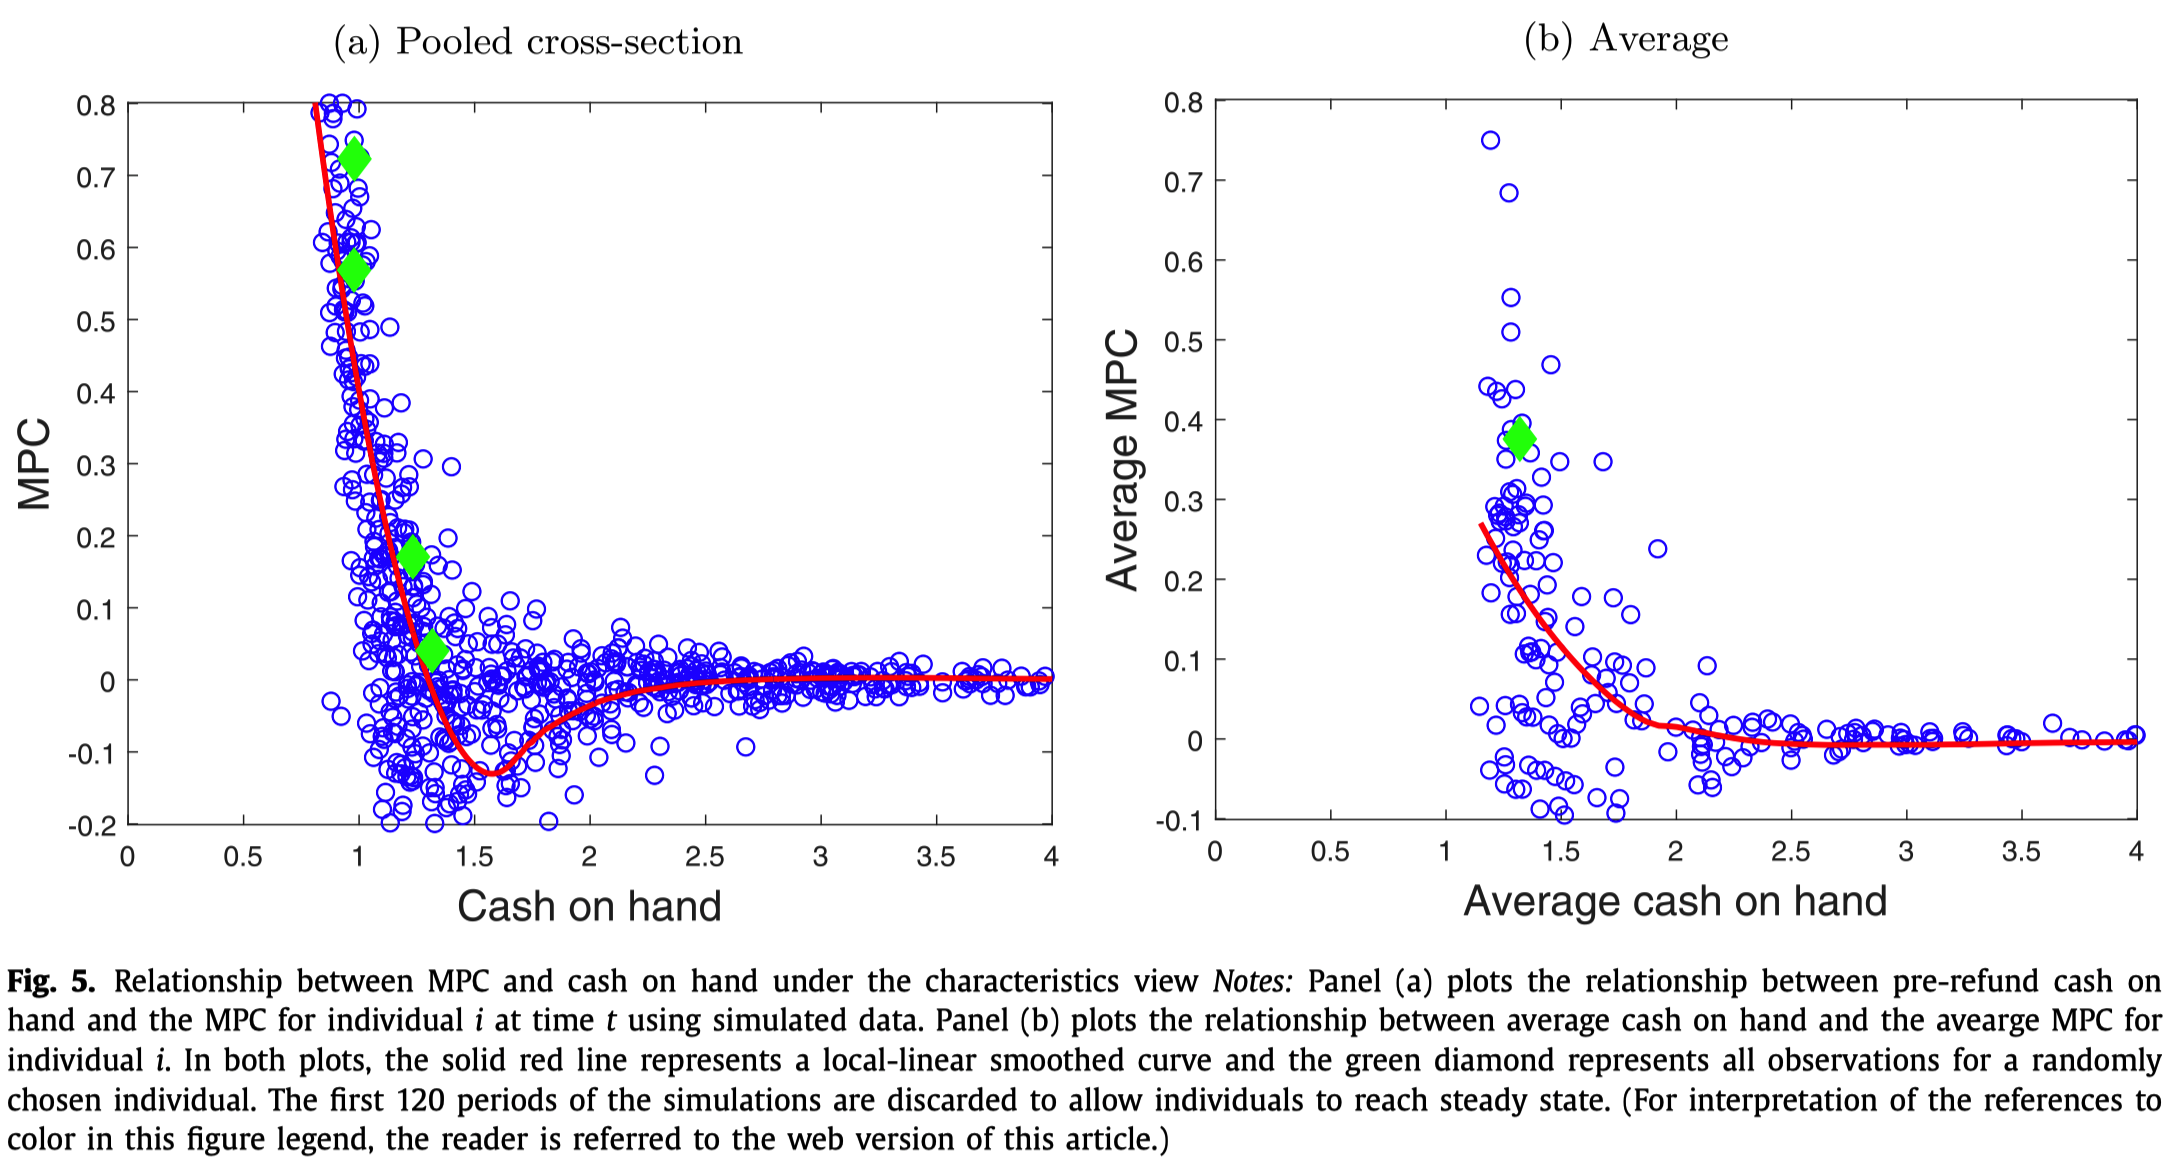

#### Variance decomposition
* a quantitative measure that decomposes the relative role of circumstances and characteristics in explaining the MPC variance
    - $MPC_{i t}=\alpha+\underbrace{\gamma_{1} \times \overline{coh}_{i}}_{\text {characteristics}}+\underbrace{\gamma_{2} \times\left(coh_{i t}^{P R}-\overline{coh}_{i}^{P R}\right)}_{\text {circumstances}}+\varepsilon_{i t}\;$, where $\mathbb{E}(\epsilon_{it}) = 0$.
* so the variance is
   - $\operatorname{var}\left(MPC_{i t}\right)=\operatorname{var}(\alpha)+\operatorname{var}\left(\gamma_{1} \times \overline{\operatorname{coh}}_{i}\right)+\operatorname{var}\left(\gamma_{2} \times\left(\operatorname{coh}_{i t}^{P R}-\overline{\operatorname{coh}}_{i}^{P R}\right)\right)+\operatorname{var}\left(\varepsilon_{i t}\right)$
* fraction explained by cash on hand that is attributable to characteristics
    - $\operatorname{var}\left(\gamma_{1} \times \overline{\operatorname{coh}}_{i}\right)=\sigma_{\text {char }}^{2}$
    - $\operatorname{var}\left(\gamma_{2} \times\left(\operatorname{coh}_{i t}^{P R}-\overline{\operatorname{coh}}_{i}^{P R}\right)\right)=\sigma_{\text {circ }}^{2}$
    - $\phi_{\text {char }}=\frac{\sigma_{\text {char }}^{2}}{\sigma_{\text {char }}^{2}+\sigma_{\text {circ }}^{2}}$

#### HARK result

##### Circumstances View (experimental code 2)

In [14]:
# simulation for distribution of cash on hand
# 200 consumers
IdiosyncDictCircumView={
    # Parameters shared with the perfect foresight model
    "CRRA": 1.00000000000001,                           # Coefficient of relative risk aversion
    "Rfree": 1 + 0.01/12,                         # Interest factor on assets
    "DiscFac": 0.9941,                       # Intertemporal discount factor, monthly frequency
    "LivPrb" : 12*[1.0],                     # Survival probability, 0.99979
    "PermGroFac" : [1.0, 1.0, 1.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], # Permanent income growth factor
    
    #Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : 12*[0.000001],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : 12*[0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.00,                     # Probability of unemployment while working
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other paramaters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 12,                        # Number of periods in the cycle for this agent type
                                           # from example, T_cycle = 4 means quarterly data
                                           # https://hark.readthedocs.io/en/latest/example_notebooks/IndShockConsumerType.html?highlight=quarterly#

    # Parameters only used in simulation
    "AgentCount" : 200,                  # Number of agents of this type
    "T_sim" : 120+48,                          # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

In [15]:
# circumstances view; pooled cross section
# MPC

num_consumers = 200                 # num of simulations we want

circumstances_view_consumers = IndShockConsumerType(**IdiosyncDictCircumView)
circumstances_view_consumers.solve(verbose=False)

circumstances_view_consumers.track_vars = ['aNrm','mNrm','cNrm','pLvl', 'MPCnow']
circumstances_view_consumers.initialize_sim()
circumstances_view_consumers.simulate()

{'aNrm': array([[0.04506091, 0.03626703, 0.03695723, ..., 0.03878944, 0.03618828,
         0.03663806],
        [0.11242661, 0.06057916, 0.        , ..., 0.20969124, 0.        ,
         0.02390989],
        [0.        , 0.        , 0.        , ..., 0.07886739, 0.        ,
         0.        ],
        ...,
        [0.13252695, 0.        , 0.39532605, ..., 0.20189865, 0.23129981,
         0.10993121],
        [0.1442639 , 0.        , 0.37376018, ..., 0.14082484, 0.07302558,
         0.31656063],
        [0.1603764 , 0.18724235, 0.2265029 , ..., 0.        , 0.12531447,
         0.12719583]]),
 'mNrm': array([[1.01800336, 1.00213759, 1.00338286, ..., 1.00668848, 1.00199551,
         1.002807  ],
        [1.19580664, 1.09169945, 0.87263193, ..., 1.38852491, 0.75354815,
         1.0170781 ],
        [1.26322851, 1.21133784, 0.91080317, ..., 1.55956927, 1.34970321,
         1.37363301],
        ...,
        [1.1399456 , 0.74677139, 1.51507352, ..., 1.24500194, 1.28786111,
         1.1039357

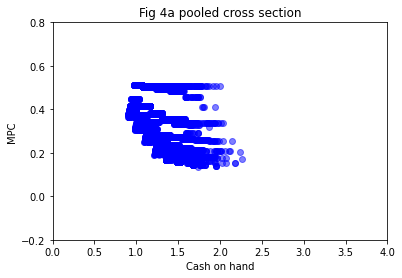

In [16]:
# plot MPC against cash on hand;
# discard first 120 periods
for i in range(num_consumers):
    plt.scatter(circumstances_view_consumers.history['mNrm'][120:,i], 
                circumstances_view_consumers.history['MPCnow'][120:,i], color = 'b', alpha=0.5)
    
plt.xlabel('Cash on hand')
plt.ylabel('MPC')

plt.title('Fig 4a pooled cross section', fontsize=12)
plt.xlim(0, 4)
plt.ylim(-0.2, 0.8)
plt.show()

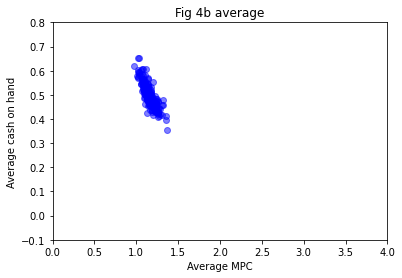

In [17]:
# plot average MPC against average cash on hand;
for i in range(num_consumers):
    plt.scatter(np.average(circumstances_view_consumers.history['mNrm'][120:,i]), 
                np.average(circumstances_view_consumers.history['MPCnow'][120:,i]), color = 'b', alpha=0.5)
    
plt.xlabel('Average MPC')
plt.ylabel('Average cash on hand')
plt.xlim(0, 4)
plt.ylim(-0.1, 0.8)
plt.title('Fig 4b average', fontsize=12)
plt.show()

##### Characteristics View (experimental code 2)

In [18]:
# simulation for distribution of cash on hand
# 200 consumers
IdiosyncDictCharView={
    # Parameters shared with the perfect foresight model
    "CRRA": 1.00000000000001,                           # Coefficient of relative risk aversion
    "Rfree": 1 + 0.01/12,                         # Interest factor on assets
    "DiscFac": 0.9941,                       # Intertemporal discount factor, monthly frequency
    "LivPrb" : 12*[1.0],                     # Survival probability, 0.99979
    "PermGroFac" : [1.0, 1.0, 1.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], # Permanent income growth factor
    
    #Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : 12*[0.000001],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : 12*[0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.00,                     # Probability of unemployment while working
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other paramaters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 12,                        # Number of periods in the cycle for this agent type
                                           # from example, T_cycle = 4 means quarterly data
                                           # https://hark.readthedocs.io/en/latest/example_notebooks/IndShockConsumerType.html?highlight=quarterly#

    # Parameters only used in simulation
    "AgentCount" : 1,                  # Number of agents of this type
    "T_sim" : 120+48,                          # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

In [19]:
from HARK.distribution import Uniform

num_consumer_types = 200   # num of types we want
char_view_consumers = []   # initialize an empty list

charConsumer = IndShockConsumerType(**IdiosyncDictCharView)

discFacDispersion = 0.0190
bottomDiscFac     = 0.9941 - discFacDispersion
topDiscFac        = 0.9941 + discFacDispersion

# draw discFac from uniform distribution with U(0.9941 - \Delta, 0.9941 + \Delta)
DiscFac_list  = Uniform(bot=bottomDiscFac,top=topDiscFac,seed=606).approx(N=num_consumer_types).X

# now create types with different disc factors
for i in range(num_consumer_types):
    newConsumer = deepcopy(charConsumer)
    newConsumer.DiscFac    = DiscFac_list[i]
    newConsumer.AgentCount = 1
    newConsumer.T_sim      = 120+48
    newConsumer.update_income_process()
    newConsumer.solve()
    
    char_view_consumers.append(newConsumer)

# simulate and keep track mNrm and MPCnow
for i in range(num_consumer_types):
    char_view_consumers[i].track_vars = ['aNrm','mNrm','cNrm','pLvl', 'MPCnow']
    char_view_consumers[i].initialize_sim()
    char_view_consumers[i].simulate()

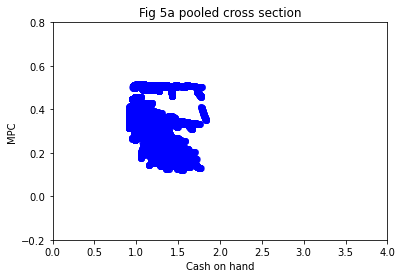

In [20]:
# plot MPC against cash on hand;
for i in range(num_consumers):
    plt.scatter(char_view_consumers[i].history['mNrm'], 
                char_view_consumers[i].history['MPCnow'], color = 'b', alpha=0.5)
    
plt.xlabel('Cash on hand')
plt.ylabel('MPC')

plt.xlim(0, 4)
plt.ylim(-0.2, 0.8)
plt.title('Fig 5a pooled cross section', fontsize=12)
plt.show()

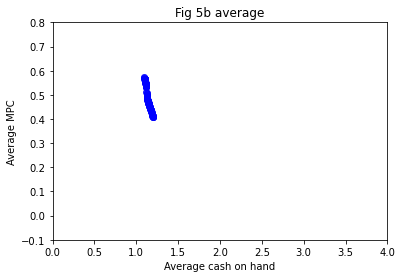

In [21]:
# plot average MPC against average cash on hand;
for i in range(num_consumers):
    plt.scatter(np.average(char_view_consumers[i].history['mNrm']), 
                np.average(char_view_consumers[i].history['MPCnow']), color = 'b', alpha=0.5)
    
plt.xlabel('Average cash on hand')
plt.ylabel('Average MPC')

plt.xlim(0, 4)
plt.ylim(-0.1, 0.8)
plt.title('Fig 5b average', fontsize=12)
plt.show()

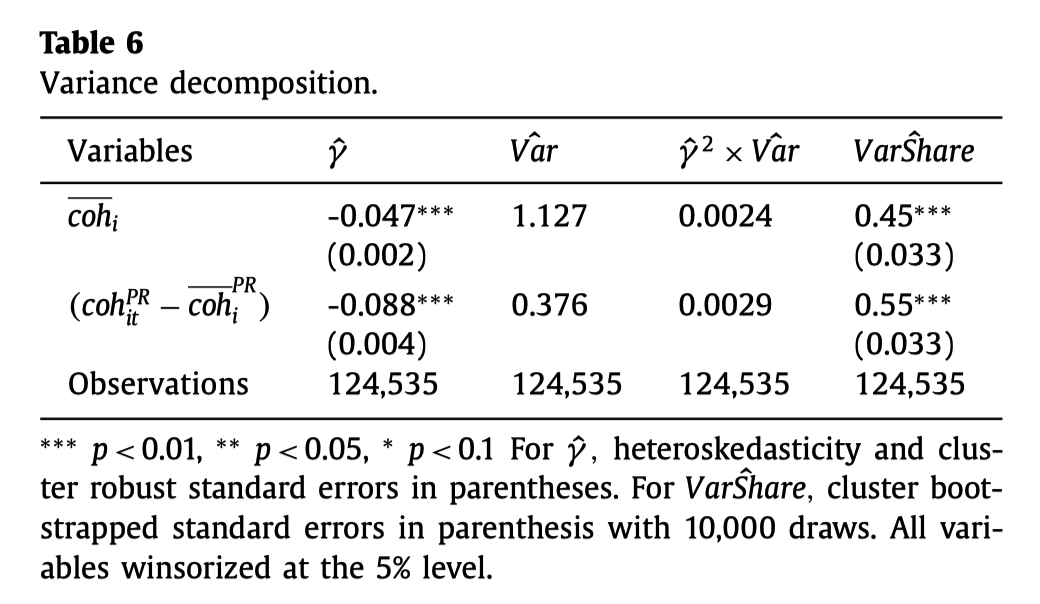